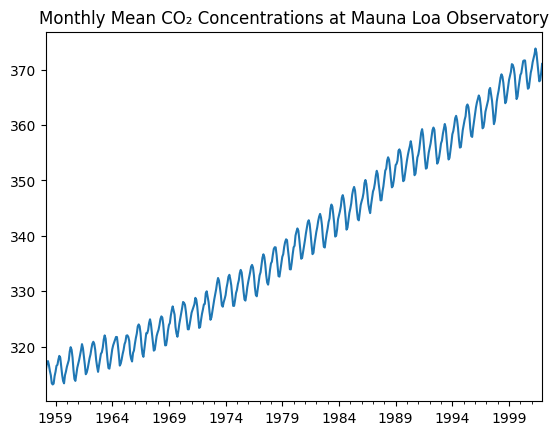

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.datasets import co2

# Load the CO2 dataset
data = co2.load_pandas().data
# Some missing data points are represented as 'NaN' in this dataset, we can fill them using interpolation
data.co2.interpolate(method='linear', inplace=True)

# Weekly data can be quite noisy, so it's often useful to resample it to monthly data
monthly_data = data.co2.resample('M').mean()

# Plot the Data
monthly_data.plot()
plt.title('Monthly Mean CO₂ Concentrations at Mauna Loa Observatory')
plt.show()

In [2]:
dates = data.index.values
print(dates)
values = data.values
print(values)

['1958-03-29T00:00:00.000000000' '1958-04-05T00:00:00.000000000'
 '1958-04-12T00:00:00.000000000' ... '2001-12-15T00:00:00.000000000'
 '2001-12-22T00:00:00.000000000' '2001-12-29T00:00:00.000000000']
[[316.1]
 [317.3]
 [317.6]
 ...
 [371.2]
 [371.3]
 [371.5]]


ADF Statistic: 2.3975099045093553
p-value: 0.9990091329588969


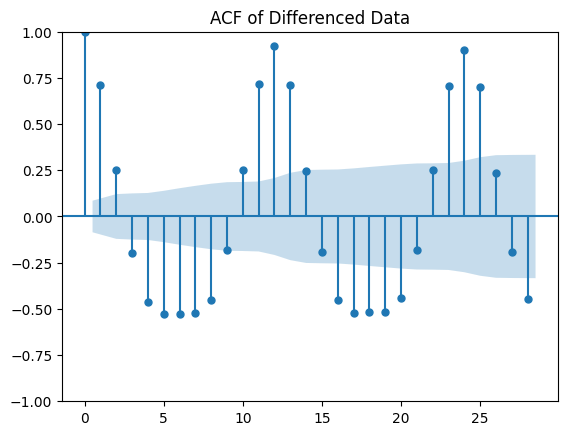

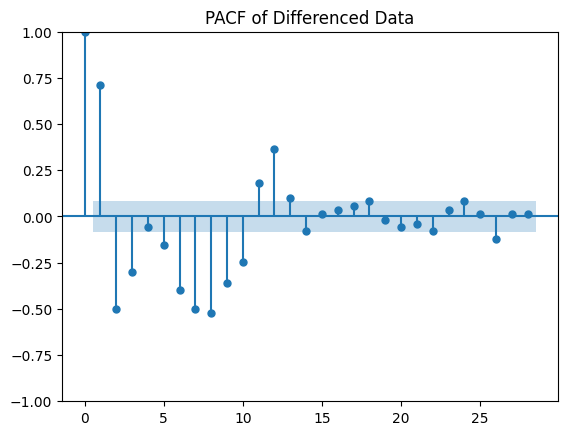

In [7]:
# Check for Stationarity
result = adfuller(monthly_data.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Differencing to make the series stationary if necessary
if result[1] > 0.05:
    monthly_data_diff = monthly_data.diff().dropna()

# Plot ACF and PACF
plot_acf(monthly_data_diff.dropna())
plt.title('ACF of Differenced Data')
plt.show()

plot_pacf(monthly_data_diff.dropna())
plt.title('PACF of Differenced Data')
plt.show()


/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                  525
Model:                ARIMA(12, 2, 2)   Log Likelihood                -198.819
Date:                Thu, 16 Nov 2023   AIC                            427.637
Time:                        13:11:29   BIC                            491.531
Sample:                    04-30-1958   HQIC                           452.661
                         - 12-31-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1736      0.103    -11.364      0.000      -1.376      -0.971
ar.L2         -1.1858      0.095    -12.445      0.000      -1.373      -0.999
ar.L3         -1.2128      0.086    -14.117      0.0

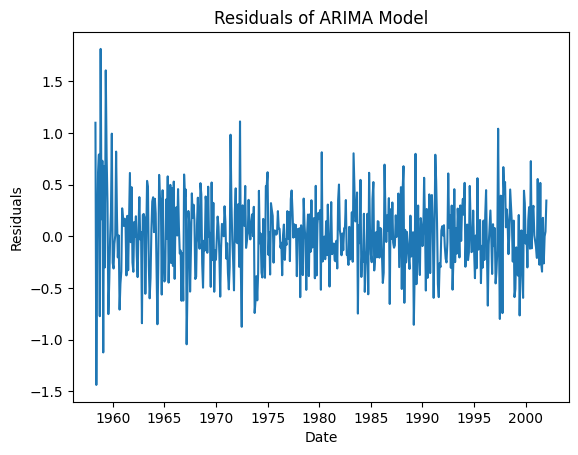

In [39]:

# Fit ARIMA Model
# Replace p, d, q with the identified order parameters after examining the ACF and PACF plots
p = 12  # example value
d = 2  # differencing is often necessary for this dataset
q = 2  # example value

model = ARIMA(monthly_data_diff, order=(p, d, q))
model_fit = model.fit()

# Model Summary
print(model_fit.summary())

# Plot Residuals
residuals = pd.DataFrame(model_fit.resid)
plt.figure()
plt.plot(residuals.index, residuals[0])
plt.title('Residuals of ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

In [40]:
import plotly.express as px
# Forecasting
forecast = model_fit.forecast(steps=100)

# Evaluate Model
forecast
dff = pd.concat([monthly_data, forecast])
px.line(dff)

In [41]:
import plotly.express as px

# The last actual observed value
last_observation = monthly_data.iloc[-1]

# Forecasting
forecast = model_fit.forecast(steps=100)

# Reintegrating the forecast
forecast_original = last_observation + forecast.cumsum()

# Evaluate Model
forecast
dff = pd.concat([monthly_data, forecast_original])
px.line(dff)